Score and explain a `drafttopic` prediction.

## Requirements

To run this code yourself, it's recommended to use virtualenv.  Dependencies are as follows,

    pip install -r requirements.txt
    
    cd ~ && git clone http://github.com/wiki-ai/drafttopic

In [1]:
import os.path

from revscoring import Model

model_path = os.path.expanduser("~/drafttopic/models/enwiki.drafttopic.gradient_boosting.model")
sm = Model.load(open(model_path), error_on_env_check=False)

/home/awight/venv/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Differences between the current environment and the environment in which the model was constructed environment were detected:
 - version '#1 SMP Debian 4.9.65-3+deb9u2 (2018-01-04)' mismatch with original environment '#1 SMP Wed Apr 18 14:02:11 PDT 2018'
 - release '4.9.0-5-amd64' mismatch with original environment '4.16.0'
 - platform 'Linux-4.9.0-5-amd64-x86_64-with-debian-9.4' mismatch with original environment 'Linux-4.16.0-x86_64-with-debian-9.4'
 - revscoring_version '2.2.3' mismatch with original environment '2.2.5'


In [2]:
import mwapi
from revscoring.extractors import api

extractor = api.Extractor(mwapi.Session("https://en.wikipedia.org", user_agent="ORES-LIME demo"))

Pick a revision, extract the features and score.

In [3]:
import numpy as np
from revscoring.datasources import revision_oriented

# Initial revision for "Zatrachydidae"
# rev_to_score = 44346279
rev_to_score = 42344094
print("https://en.wikipedia.org/?oldid={}".format(rev_to_score))

original_text = list(extractor.extract(rev_to_score, [revision_oriented.revision.text]))[0]
print(original_text)

https://en.wikipedia.org/?oldid=42344094
'''John Davis''' an [[American]] and [[seal]] hunter who claimed to have first set foot on [[Antarctica]] on February 7, [[1821]].


In [4]:
features = [str(f) for f in sm.features]
feature_values = np.array(list(extractor.extract(rev_to_score, sm.features)))

prediction = sm.score(feature_values)

import operator
sorted(prediction["probability"].items(), key=operator.itemgetter(1), reverse=True)

[('Culture.Language and literature', 0.5791824638170249),
 ('Geography.Countries', 0.3864267805975978),
 ('History_And_Society.History and society', 0.12771131153070786),
 ('STEM.Geosciences', 0.0814095975211992),
 ('Culture.Sports', 0.08120918711989812),
 ('Geography.Oceania', 0.06478403548104734),
 ('History_And_Society.Military and warfare', 0.06038004482368806),
 ('STEM.Biology', 0.05608502143838874),
 ('Geography.Europe', 0.052775294493675996),
 ('Geography.Maps', 0.04365371048467642),
 ('Assistance.Maintenance', 0.04044361162431293),
 ('Culture.Visual arts', 0.021829483813867425),
 ('Geography.Bodies of water', 0.011764306734145118),
 ('Culture.Entertainment', 0.011494598383643589),
 ('Culture.Broadcasting', 0.01032794084965132),
 ('History_And_Society.Transportation', 0.008297619874529363),
 ('STEM.Physics', 0.007202913660558299),
 ('Geography.Landforms', 0.006480745325556169),
 ('History_And_Society.Politics and government', 0.006350881163692786),
 ('STEM.Technology', 0.0061068

## Explain

Why did we get this result?  Set up a LIME explainer for this model.  This type of explainer will perturb the text content of the revision being scored in order to find local gradients for each word.

In [5]:
from lime.lime_text import LimeTextExplainer

class_names = sm.info["params"]["labels"]

def score(text):
    cache = {"datasource.revision.text": text}
    feature_values = np.array(list(extractor.extract(rev_to_score, sm.features, cache=cache)))
    probabilities = sm.score(feature_values)["probability"]
    return np.array([probabilities[k] for k in class_names])

def score_all(samples):
    raw_results = [score(v) for v in samples]
    return np.array(raw_results)

explainer = LimeTextExplainer(
    class_names=class_names
)

Calculate the explanation for this prediction.  Note: this may take 5 minutes or longer.

In [6]:
exp = explainer.explain_instance(
    original_text,
    score_all,
    num_features=20,
    top_labels=3
)


/home/awight/venv/lib/python3.5/re.py:203: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


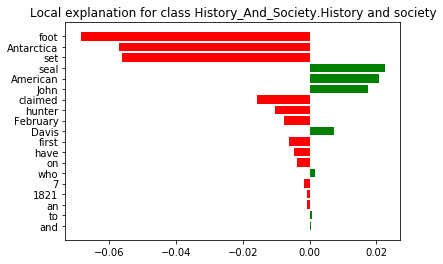

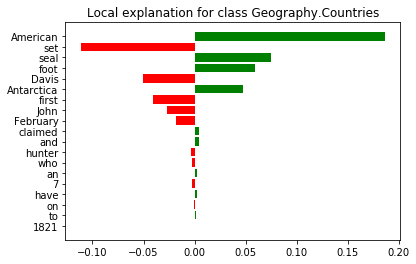

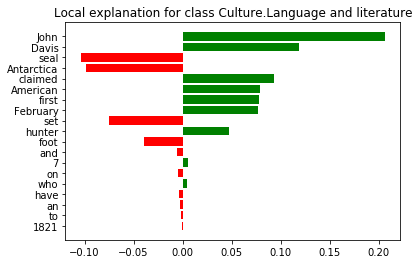

In [7]:
%matplotlib inline
for label_index in exp.local_exp.keys():
    fig = exp.as_pyplot_figure(label=label_index)